In [2]:
import pandas as pd
import numpy as np
import string

In [3]:
lines= pd.read_table('C:/Users/user/Desktop/딥러닝교재/제 12장 머신번역(n)/english to french/english to french.txt', names=['eng', 'fr'])


In [4]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [5]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [6]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [7]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [8]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [9]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [10]:
lines.shape

(50000, 2)

In [11]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [12]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [13]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [14]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [15]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [16]:
filter_eng_words('he is extremely good')

'he is unk good '

In [17]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [18]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [19]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [20]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [21]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [22]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [23]:
len(all_eng_words)

385

In [24]:
len(target_words)

358

In [25]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [26]:
num_decoder_tokens

358

In [27]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [28]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [29]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [30]:
print(eng_max_length)
print(fr_max_length)

8
17


In [31]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [32]:
decoder_target_data.shape

(50000, 17, 359)

In [33]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [34]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [35]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
encoder_states = [state_h, state_c]

In [37]:
decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1, 128)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dex,initial_state=encoder_states)
decoder_outputs = Dense(2000,activation='tanh')(decoder_outputs)
decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')(decoder_outputs)

model2 = Model([encoder_inputs, decoder_inputs], decoder_dense)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [38]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 128)       49408       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      45952       input_2[0][0]                    
______________________________________________________________________________________________

In [39]:
history2 = model2.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
372/372 [==============================] - 102s 258ms/step - loss: 1.4545 - acc: 0.7765 - val_loss: 1.0526 - val_acc: 0.7884
Epoch 2/5
372/372 [==============================] - 92s 247ms/step - loss: 0.7165 - acc: 0.8502 - val_loss: 0.8364 - val_acc: 0.8138
Epoch 3/5
372/372 [==============================] - 91s 246ms/step - loss: 0.5486 - acc: 0.8723 - val_loss: 0.7001 - val_acc: 0.8319
Epoch 4/5
372/372 [==============================] - 92s 247ms/step - loss: 0.4559 - acc: 0.8866 - val_loss: 0.6269 - val_acc: 0.8449
Epoch 5/5
372/372 [==============================] - 92s 247ms/step - loss: 0.3942 - acc: 0.8975 - val_loss: 0.5868 - val_acc: 0.8515


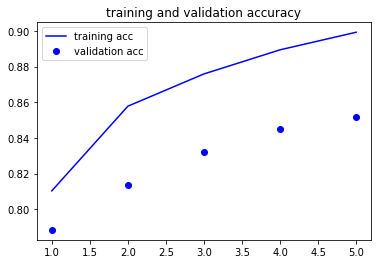

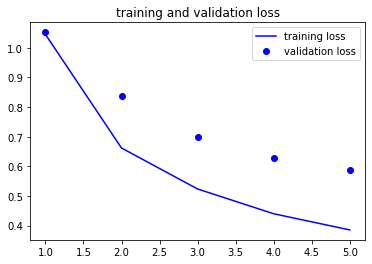

In [40]:
import matplotlib.pyplot as plt
acc=history2.history['acc']
val_acc=history2.history['val_acc']
loss=history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [41]:
decoder_target_data.shape

(50000, 17, 359)

In [42]:
act = np.argmax(decoder_target_data, axis=2)
act.shape

(50000, 17)

In [43]:
act[5000]

array([134,  83, 320,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89], dtype=int64)

In [44]:
count = 0
correct_count = 0
pred = model2.predict([encoder_input_data[47500:],decoder_input_data[47500:]])
for i in range(2500):
  t = np.argmax(pred[i], axis=-1)
  correct_count += np.sum((act[47500+i]==t) & (act[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
print(correct_count,count)
print(correct_count/count)

7264 15926
0.4561095064674118


In [45]:
target_token_index['end']

89

In [46]:
decoder_input_data_pred = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_input_data_pred.shape

(50000, 17)

In [48]:
final_pred = []
for i in range(2500):
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model2.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0,j])
    word = t
    if word==89:
      break
  final_pred.append(list(decoder_input_data_pred[47500+i]))

In [49]:
final_pred2 = np.array(final_pred)
final_pred2.shape

(2500, 17)

In [50]:
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count

0.4776466155971368